In [2]:
%reset -f
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
import cv2
from scipy import ndimage

global i,pi
i = np.complex(0,1)
pi = np.pi

#import image
BGR_pic = cv2.imread('../pictures/lenna.tiff')
pic = cv2.cvtColor(BGR_pic, cv2.COLOR_BGR2RGB)
bw_pic = cv2.cvtColor(pic, cv2.COLOR_BGR2GRAY)

from skimage.transform import rescale
bw_pic = rescale(bw_pic, 0.5, anti_aliasing=True)
bw_pic.shape

(256, 256)

In [3]:
#normalize to values 0 and 1
def normalize(data):
    return (data-np.min(data))/(np.max(data)-np.min(data))

#normalize to values 0 and 255
def normu8(data):
    return ( 255*(data-np.min(data))/(np.max(data)-np.min(data)) ).astype(np.uint8)

#normalize to values (-1) and 1
def distribute(data):
    return (data-np.min(data))/(np.max(data)-np.min(data))*2 -1

In [4]:
def thresholding(image,threshold=0.5):
    #image_internal = np.copy(image)
    image = normalize(image)
    mask = image>threshold
    return np.multiply(image,mask)

def binary(image,threshold=0.5):
    #image_internal = np.copy(image)
    image = normalize(image)
    mask = image>threshold
    return mask

In [39]:
def slow_convolution(A,B):
    print('implemented convolution. differences at the edges are possible !!!')
    dimA = np.shape(A)
    dimB = np.shape(B)
    conv_bounds = (dimA[0]-dimB[0]-1,dimA[1]-dimB[1]-1)
    result = np.zeros( np.array( conv_bounds ) )
    for ii in range(0,conv_bounds[0]):
        for iii in range(0,conv_bounds[1]):
            result[ii,iii] = np.sum(np.multiply(A[ii:ii+dimB[0],iii:iii+dimB[1]],B))
    return result
def fourier_convolution(A,B):
    print('implemented convolution. differences at the edges are possible !!!')
    dimA = np.shape(A)
    dimB = np.shape(B)
    #next power of two => efficient fft and automatic zero padding
    size = 2**np.ceil(np.log2(dimA)).astype(int)
    #fft trafo image
    aa = np.fft.fft2(A)
    #fft trafo kernel
    bb = np.fft.fft2(B, dimA)
    #multiply in fourier space
    cc = np.multiply( aa , bb )
    #reverse fft trafo
    C = np.fft.ifft2( cc )
    return np.real( C )
def reverse_convolution(A,B):
    print('reverse convolution by division with filter in fourier space.')
    dimA = np.shape(A)
    dimB = np.shape(B)
    #fft trafo image
    aa = np.fft.fft2(A)
    #fft trafo kernel
    bb = np.fft.fft2(B, dimA)
    #divide in fourier space
    cc = np.divide( aa , bb )
    
    #keep small values at zero for numerical stability when dividing by zero
    mask = np.logical_and( np.abs(aa)>1e-22 , np.abs(bb)>1e-16 )
    cc = np.multiply( cc , mask)
    
    #reverse fft trafo
    C = np.fft.ifft2( cc )
    return C

In [6]:
def gaussian_kernel(size, sigma=1):
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    c = 1 / (2.0 * pi * sigma**2)
    return c * np.exp(-(x**2 + y**2) / (2.0*sigma**2))

In [7]:
def discrete_angle_indices(angle,orientation):
    if abs(angle)>7/8*pi or abs(angle)<1/8*pi: #horizontal
        if orientation == 'gradient':
            row = np.array([-1,0,1])
            col = np.array([0,0,0])
        elif orientation == 'perpendicular':
            row = np.array([0,0,0])
            col = np.array([-1,0,1])
    elif abs(angle)>3/8*pi and abs(angle)<5/8*pi: #vertical
        if orientation == 'gradient':
            row = np.array([0,0,0])
            col = np.array([-1,0,1])
        elif orientation == 'perpendicular':
            row = np.array([-1,0,1])
            col = np.array([0,0,0])
    elif angle<-pi/2 or (angle>0 and angle<pi/2): #orientation: /
        if orientation == 'gradient':
            row = np.array([-1,0,1])
            col = np.array([-1,0,1])
        elif orientation == 'perpendicular':
            row = np.array([1,0,-1]) 
            col = np.array([-1,0,1])
    else: #orientation: \
        if orientation == 'gradient':
            row = np.array([1,0,-1]) 
            col = np.array([-1,0,1])
        elif orientation == 'perpendicular':
            row = np.array([-1,0,1])
            col = np.array([-1,0,1])
    return row,col

In [8]:
def non_maximum_suppression(amplitude,phase,t_high=80):
    #image_internal = np.copy(amplitude)
    dim = np.shape(amplitude)
    #amplitude = normu8(amplitude)
    
    image_suppressed = np.copy(amp)
    
    for ii in range(0,dim[0]):
        for iii in range(0,dim[1]):
            
            #indices of image pixels along the gradient
            row,col = discrete_angle_indices(phase[ii,iii],'gradient')
            col = col + ii
            row = row + iii
            
            #if neighbour pixel along gradient are bigger, than set pixel intensity below t_high
            #beware index out of bonds
            intensity = amplitude[ii,iii]
            for pos in [0,2]:
                try:
                    if amplitude[col[pos],row[pos]] > intensity:
                        image_suppressed[ii,iii] = t_high-1e-3
                except IndexError:
                    pass
            
    return image_suppressed

In [9]:
def hysteresis_thresholding(amplitude,phase,t_high=180,t_low=80):
    #image_internal = np.copy(amplitude)
    dim = np.shape(amplitude)
    #amplitude = normu8(amplitude)
    
    # pixels, that have amplitude over t_high are automatically included
    filtered = amplitude>t_high
    filtered = filtered.astype(int)
    [a,b] = np.nonzero(filtered)
    
    #set of indices of this elements
    indices = set()
    for c,r in zip(a,b):
        indices.add((c,r))
    
    done = indices.copy()
    
    while len(indices) > 0: #while list of indices not empty search for neighbours
        index = indices.pop()
        
        #indices of image pixels perpendicular to gradient
        row,col = discrete_angle_indices(phase[index],'perpendicular')
        
        #test selected pixels: if they have amplitude higher t_low they are also included
        for pos in [0,2]:
            cc = index[0] + col[pos]
            rr = index[1] + row[pos]
            ind = (cc,rr)
            if ind not in done:
                    #beware index out of bonds
                    try:
                        if amplitude[ind] > t_low:
                            filtered[ind] = 1
                            done.add(ind)
                            if ind not in indices:
                                indices.add(ind)
                    except IndexError:
                        pass
    
    return filtered

In [10]:
### erosion / dilation 
# filter of 3x3 ones used (other filters possible !!!)
# calculates min / max inside this box for each position

def erosion(image):
    dim = np.shape(image)
    eroded = np.zeros(dim)
    for xx in range(0+1,dim[0]-1):
        for yy in range(0+1,dim[1]-1):
            try: eroded[xx][yy] = np.min(image[xx-1:xx+2,yy-1:yy+2])
            except: print('error at coordinate:',xx,yy)
    return eroded

def dilation(image):
    dim = np.shape(image)
    dilated = np.zeros(dim)
    for xx in range(0+1,dim[0]-1):
        for yy in range(0+1,dim[1]-1):
            try: dilated[xx][yy] = np.max(image[xx-1:xx+2,yy-1:yy+2])
            except: print('error at coordinate:',xx,yy)
    return dilated

In [11]:
#median filtering
def median_filter(image):
    dim = np.shape(image)
    median_pic = np.zeros(dim)
    for xx in range(0+1,dim[0]-1):
        for yy in range(0+1,dim[1]-1):
            median_pic[xx][yy] = np.median(image[xx-1:xx+2,yy-1:yy+2])
    return median_pic

In [12]:
def compute_histogram(bw_pic):
    
    bins = 256
    dim=np.shape(bw_pic)
    
    histogram = np.zeros(bins, dtype=int)
    
    #note: by normalizing image between 0 and 1 => histogram gets stretched between zero and 1
    binned_image = np.round( (bins-1)*normalize(bw_pic) )
    binned_image.astype(int)

    for xx in range(0,dim[0]):
        for yy in range(0,dim[1]):
            value = int( binned_image[xx,yy] )
            histogram[value] += 1

    cummulative = np.zeros(bins, dtype=int)

    cummulative[0] = histogram[0]
    for kk in range(1,bins):
        cummulative[kk] = cummulative[kk-1] + histogram[kk]
    
    return histogram,cummulative

def normalize_histogram(image,cummulative):
    
    bins = 256
    dim=np.shape(image)
    
    image = normalize(image) * (bins-1)
    image = image.astype(int)
    
    cummulative = normalize(cummulative) * (bins-1)
    cummulative = cummulative.astype(int)
    
    normalized_image = np.zeros(dim,dtype=int)
    for xx in range(0,dim[0]):
        for yy in range(0,dim[1]):
            normalized_image[xx,yy] = cummulative[image[xx,yy]]

    return normalized_image

------------

In [26]:
pic.max() , pic.dtype , bw_pic.max() , bw_pic.dtype

(255, dtype('uint8'), 0.8803921568627454, dtype('float64'))

Text(0.5, 1.0, 'original')

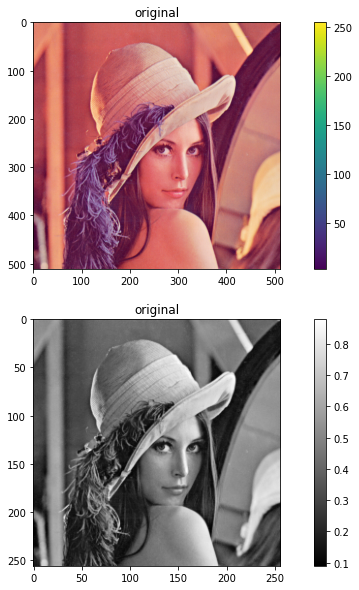

In [40]:
#plot original
fig = plt.figure(figsize=(12,10))

plt.subplot(2,1,1)
plt.imshow(pic)
plt.colorbar()
plt.title('original')
#plt.axis('off')

plt.subplot(2,1,2)
plt.imshow(bw_pic, cmap='gray')#negative cmap='Greys'
plt.colorbar()
plt.title('original')
#plt.axis('off')

In [28]:
#sobel edge detector
sobelH = np.array([[-1,0,1],
                   [-2,0,2],
                   [-1,0,1]])
sobelV = np.array([[1,2,1],
                   [0,0,0],
                   [-1,-2,-1]])
horz = fourier_convolution(bw_pic,sobelH)
vert = fourier_convolution(bw_pic,sobelV)
sobel = horz + i*vert
amp = np.absolute(sobel)
pha = np.angle(sobel)

#amp = normu8(amp)
#pha = np.mod(pha, np.pi)

implemented convolution. differences at the edges are possible !!!
implemented convolution. differences at the edges are possible !!!


(-0.5, 255.5, 255.5, -0.5)

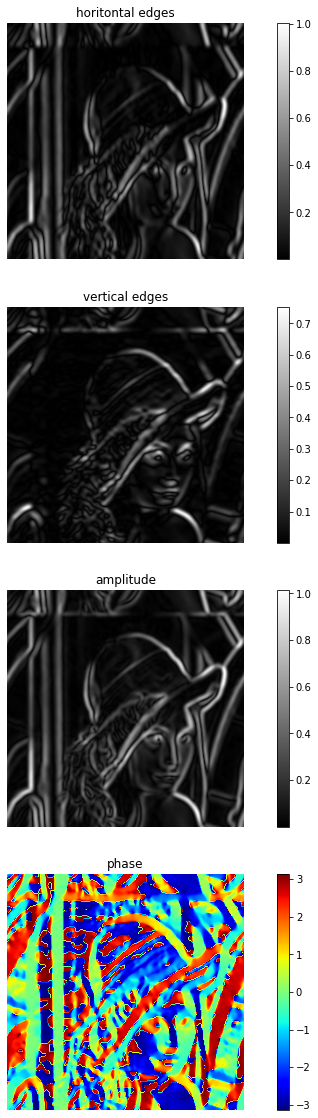

In [41]:
#plot filter
fig = plt.figure(figsize=(12,20))

plt.subplot(4,1,1)
plt.imshow(np.abs(horz), cmap='gray')
plt.colorbar()
plt.title('horitontal edges')
plt.axis('off')

plt.subplot(4,1,2)
plt.imshow(np.abs(vert), cmap='gray')
plt.colorbar()
plt.title('vertical edges')
plt.axis('off')

plt.subplot(4,1,3)
plt.imshow(amp, cmap='gray')
plt.colorbar()
plt.title('amplitude')
plt.axis('off')

plt.subplot(4,1,4)
plt.imshow(pha, cmap='jet')
plt.colorbar()
plt.title('phase')
plt.axis('off')

In [43]:
# canny edge detector
# high amplitude edges are considered true edges (thresholding)
# lower amplitude edges are only considered edges, if they are connected to high amplitude edges
# (following perpendicular to the edge normal from high intensity edges)

#smoothing
#bw_pic = median_filter(bw_pic)
#gauss_kernel = gaussian_kernel(111,2)
gauss_kernel = gaussian_kernel(51,2)
gaussBlur = fourier_convolution(bw_pic,gauss_kernel)

#canny edge detector
sobelH = np.array([[-1,0,1],
                   [-2,0,2],
                   [-1,0,1]])
sobelV = np.array([[1,2,1],
                   [0,0,0],
                   [-1,-2,-1]])
horz = fourier_convolution(gaussBlur,sobelH)
vert = fourier_convolution(gaussBlur,sobelV)
sobel = horz + i*vert
amp=np.absolute(sobel);pha=np.angle(sobel)

#amp = normu8(amp)
#pha = np.mod(pha, np.pi)

sobel_suppressed = non_maximum_suppression(amp,pha,0.1)
canny = hysteresis_thresholding(sobel_suppressed,pha,0.1,0.2) #higher number => less lines


implemented convolution. differences at the edges are possible !!!
implemented convolution. differences at the edges are possible !!!
implemented convolution. differences at the edges are possible !!!


(-0.5, 255.5, 255.5, -0.5)

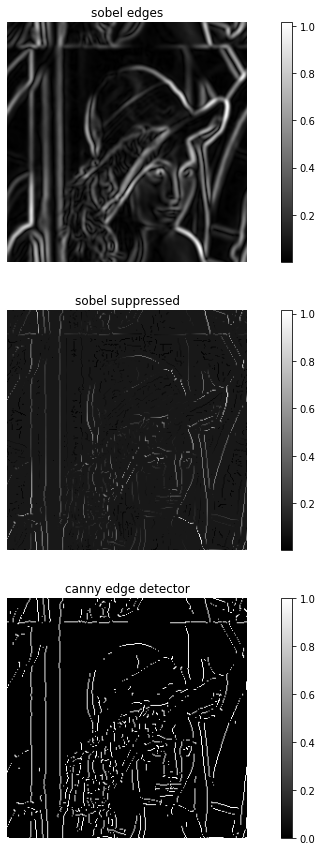

In [44]:
#plot filter
fig = plt.figure(figsize=(12,15))

plt.subplot(3,1,1)
plt.imshow(np.absolute(sobel), cmap='gray')
plt.colorbar()
plt.title('sobel edges')
plt.axis('off')

plt.subplot(3,1,2)
plt.imshow(np.absolute(sobel_suppressed), cmap='gray')
plt.colorbar()
plt.title('sobel suppressed')
plt.axis('off')

plt.subplot(3,1,3)
plt.imshow(canny, cmap='gray')
plt.colorbar()
plt.title('canny edge detector')
plt.axis('off')

(-0.5, 255.5, 255.5, -0.5)

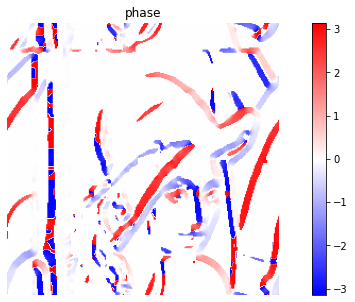

In [45]:
#plot filter
fig = plt.figure(figsize=(12,5))

plt.subplot(1,1,1)
plt.imshow(pha*(amp>0.2), cmap='bwr')
plt.colorbar()
plt.title('phase')
plt.axis('off')

In [33]:
from skimage.feature import canny
edges = canny(bw_pic, sigma=1.4, low_threshold=0.1, high_threshold=0.3)

(-0.5, 255.5, 255.5, -0.5)

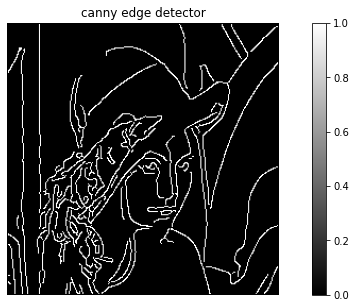

In [46]:
fig = plt.figure(figsize=(12,5))

plt.subplot(1,1,1)
plt.imshow(edges, cmap='gray')
plt.colorbar()
plt.title('canny edge detector')
plt.axis('off')

In [47]:
#gradient
gradientH = np.array([[-1,1]])
gradientV = np.array([[1],
                      [-1]])
gradhorz = fourier_convolution(bw_pic,gradientH)
gradvert = fourier_convolution(bw_pic,gradientV)
gradient = horz + i*vert


implemented convolution. differences at the edges are possible !!!
implemented convolution. differences at the edges are possible !!!


(-0.5, 255.5, 255.5, -0.5)

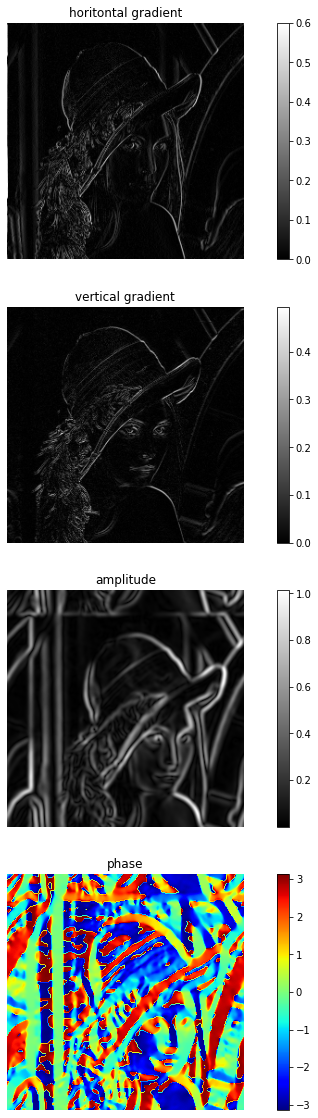

In [49]:
#plot filter
fig = plt.figure(figsize=(12,20))

plt.subplot(4,1,1)
plt.imshow(np.abs(gradhorz), cmap='gray')
plt.colorbar()
plt.title('horitontal gradient')
plt.axis('off')

plt.subplot(4,1,2)
plt.imshow(np.abs(gradvert), cmap='gray')
plt.colorbar()
plt.title('vertical gradient')
plt.axis('off')

plt.subplot(4,1,3)
plt.imshow(np.absolute(gradient), cmap='gray')
plt.colorbar()
plt.title('amplitude')
plt.axis('off')

plt.subplot(4,1,4)
plt.imshow(np.angle(gradient), cmap='jet')
plt.colorbar()
plt.title('phase')
plt.axis('off')

In [50]:
#blur
box = np.array([[1,1,1],
                [1,1,1],
                [1,1,1]])/9
gauss = np.array([[ 1, 2, 1],
                  [ 2, 4, 2],
                  [ 1, 2, 1]])/16
boxBlur = fourier_convolution(bw_pic,box)
gaussBlur = fourier_convolution(bw_pic,gauss)

implemented convolution. differences at the edges are possible !!!
implemented convolution. differences at the edges are possible !!!


(-0.5, 255.5, 255.5, -0.5)

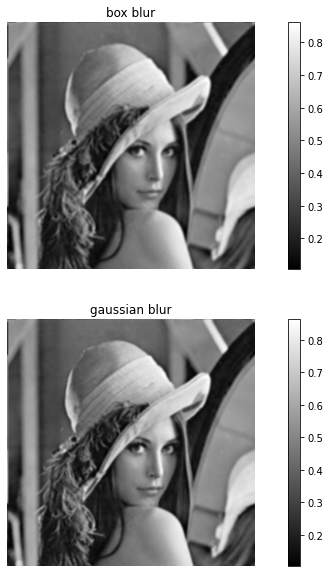

In [51]:
#plot filter
fig = plt.figure(figsize=(12,10))

plt.subplot(2,1,1)
plt.imshow(boxBlur, cmap='gray')
plt.colorbar()
plt.title('box blur')
plt.axis('off')

plt.subplot(2,1,2)
plt.imshow(gaussBlur, cmap='gray')
plt.colorbar()
plt.title('gaussian blur')
plt.axis('off')

In [52]:
#superresolution by division with convolution filter in fourier space
box = np.ones((9,9))
box = box * 1/np.sum(box)
boxBlur = np.real( fourier_convolution(bw_pic,box) )
superres = reverse_convolution(boxBlur,box)

implemented convolution. differences at the edges are possible !!!
reverse convolution by division with filter in fourier space.


(-0.5, 255.5, 255.5, -0.5)

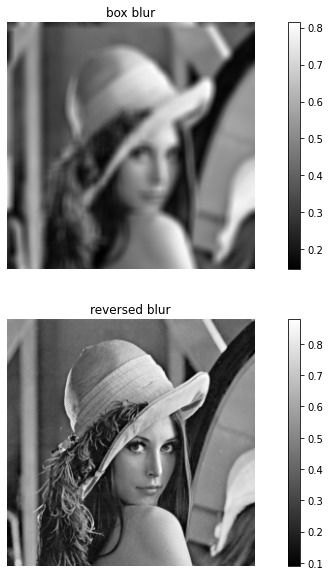

In [53]:
#plot filter
fig = plt.figure(figsize=(12,10))

plt.subplot(2,1,1)
plt.imshow(np.real(boxBlur), cmap='gray')
plt.colorbar()
plt.title('box blur')
plt.axis('off')

plt.subplot(2,1,2)
plt.imshow(np.real(superres), cmap='gray')
plt.colorbar()
plt.title('reversed blur')
plt.axis('off')

In [57]:
#sharpen
sharpen = np.array([[ 0,-1, 0],
                    [ -1,5, -1],
                    [ 0,-1, 0]])
sharpened = fourier_convolution(bw_pic,sharpen)

implemented convolution. differences at the edges are possible !!!


(-0.5, 255.5, 255.5, -0.5)

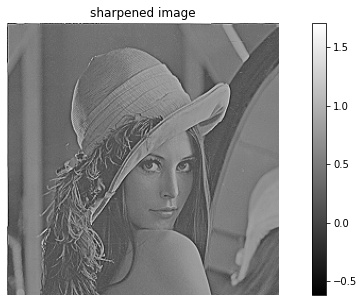

In [58]:
#plot filter
fig = plt.figure(figsize=(12,5))
plt.subplot(1,1,1)
plt.imshow(sharpened, cmap='gray')
plt.colorbar()
plt.title('sharpened image')
plt.axis('off')

In [64]:
binary_pic.dtype , eroded.dtype

(dtype('bool'), dtype('float64'))

In [65]:
#morphological operations (on binary image)
binary_pic = binary(bw_pic,0.5)
eroded = erosion(binary_pic).astype(bool)
edges = binary_pic ^ eroded #^ == xor; equal to substraction for boolean values
dilated = dilation(binary_pic).astype(bool)
opening = dilation(erosion(binary_pic)).astype(bool)
closing = erosion(dilation(binary_pic)).astype(bool)

(-0.5, 255.5, 255.5, -0.5)

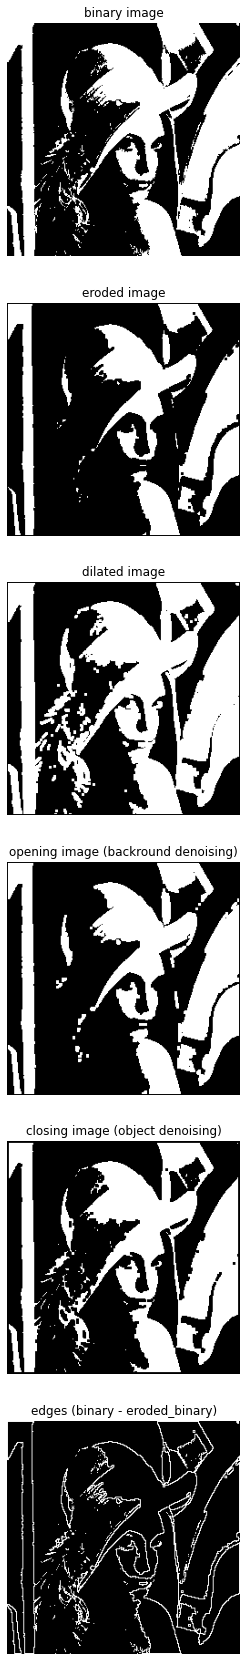

In [66]:
#plot filter
fig = plt.figure(figsize=(12,30))

plt.subplot(6,1,1)
plt.imshow(binary_pic, cmap='gray')
#plt.colorbar()
plt.title('binary image')
plt.axis('off')

plt.subplot(6,1,2)
plt.imshow(eroded, cmap='gray')
#plt.colorbar()
plt.title('eroded image')
plt.axis('off')

plt.subplot(6,1,3)
plt.imshow(dilated, cmap='gray')
#plt.colorbar()
plt.title('dilated image')
plt.axis('off')

plt.subplot(6,1,4)
plt.imshow(opening, cmap='gray')
#plt.colorbar()
plt.title('opening image (backround denoising)')
plt.axis('off')

plt.subplot(6,1,5)
plt.imshow(closing, cmap='gray')
#plt.colorbar()
plt.title('closing image (object denoising)')
plt.axis('off')

plt.subplot(6,1,6)
plt.imshow(edges, cmap='gray')
#plt.colorbar()
plt.title('edges (binary - eroded_binary)')
plt.axis('off')

In [68]:
#morphological operations (on color image)
eroded = erosion(bw_pic)
dilated = dilation(bw_pic)
opening = dilation(erosion(bw_pic))
closing = erosion(dilation(bw_pic))

(-0.5, 255.5, 255.5, -0.5)

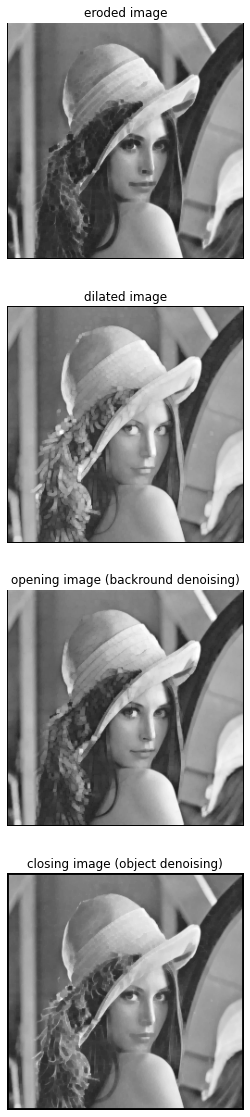

In [69]:
#plot filter
fig = plt.figure(figsize=(12,20))

plt.subplot(4,1,1)
plt.imshow(eroded, cmap='gray')
#plt.colorbar()
plt.title('eroded image')
plt.axis('off')

plt.subplot(4,1,2)
plt.imshow(dilated, cmap='gray')
#plt.colorbar()
plt.title('dilated image')
plt.axis('off')

plt.subplot(4,1,3)
plt.imshow(opening, cmap='gray')
#plt.colorbar()
plt.title('opening image (backround denoising)')
plt.axis('off')

plt.subplot(4,1,4)
plt.imshow(closing, cmap='gray')
#plt.colorbar()
plt.title('closing image (object denoising)')
plt.axis('off')


(-0.5, 255.5, 255.5, -0.5)

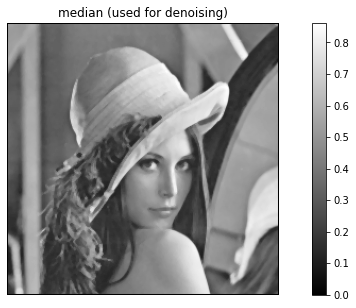

In [71]:
#median filter
pic_median = median_filter(bw_pic)

#plot filter
fig = plt.figure(figsize=(12,5))
plt.subplot(1,1,1)
plt.imshow(pic_median, cmap='gray')
plt.colorbar()
plt.title('median (used for denoising)')
plt.axis('off')

In [72]:
###histogram normalization

#compute histogram
[histogram,cummulative] = compute_histogram(bw_pic)

#histogram normalization (flatten histogram)
normalized_pic = normalize_histogram(bw_pic,cummulative)
#also adaptive equalization possible == equalization inside a small windows of the image

#compute histogram
[histogram_normalized,cummulative_normalized] = compute_histogram(normalized_pic)


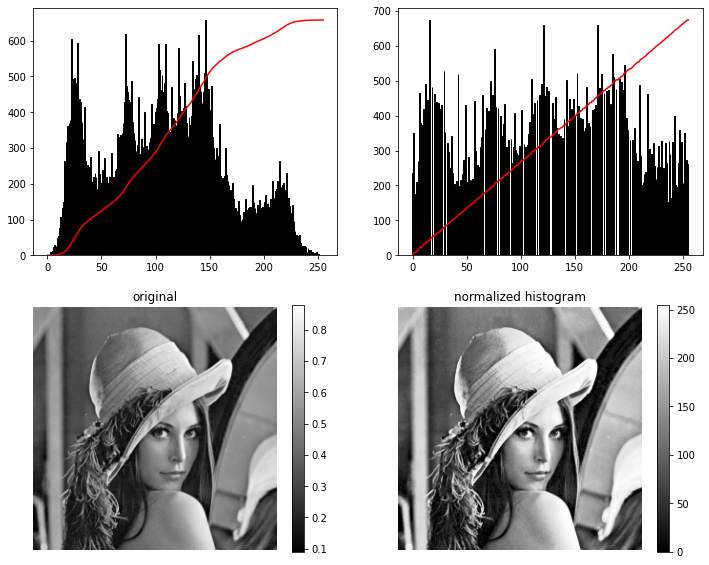

In [74]:
#plot histogram
fig = plt.figure(figsize=(12,10))

ax = plt.subplot(2,2,1)
x=np.linspace(0,255,256)
ax.bar(x,histogram, color='black', edgecolor='k')
ax.plot(x,cummulative/np.max(cummulative)*np.max(histogram), color='red')

ax = plt.subplot(2,2,2)
x=np.linspace(0,255,256)
ax.bar(x,histogram_normalized, color='black', edgecolor='k')
ax.plot(x,cummulative_normalized/np.max(cummulative_normalized)*np.max(histogram_normalized), color='red')

plt.subplot(2,2,3)
plt.imshow(bw_pic, cmap='gray')
plt.colorbar()
plt.title('original')
plt.axis('off')

plt.subplot(2,2,4)
plt.imshow(normalized_pic, cmap='gray')
plt.colorbar()
plt.title('normalized histogram')
plt.axis('off')

plt.show()

In [75]:
###histogram normalization (colored)

[histogram,cummulative] = compute_histogram(bw_pic)

#histogram normalization (flatten histogram)
normalized_pic0 = normalize_histogram(pic[:,:,0],cummulative)
normalized_pic1 = normalize_histogram(pic[:,:,1],cummulative)
normalized_pic2 = normalize_histogram(pic[:,:,2],cummulative)

modified = pic.copy()
modified[:,:,0] = normalized_pic0
modified[:,:,1] = normalized_pic1
modified[:,:,2] = normalized_pic2

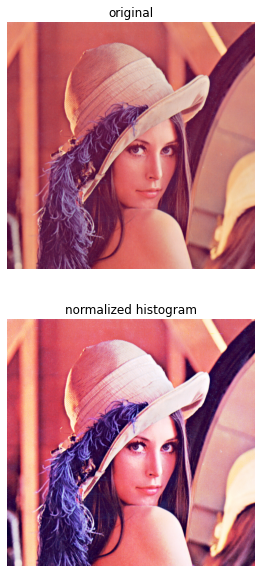

In [77]:
#plot histogram
fig = plt.figure(figsize=(12,10))

plt.subplot(2,1,1)
plt.imshow(pic, cmap='gray')
#plt.colorbar()
plt.title('original')
plt.axis('off')

plt.subplot(2,1,2)
plt.imshow(modified, cmap='gray')
#plt.colorbar()
plt.title('normalized histogram')
plt.axis('off')

plt.show()